<h1><center>Проект Автомобили</center></h1>

## Описание проекта <a class="anchor" id="1-bullet"></a>

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.


Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

Данные находятся в файле /datasets/autos.csv

- Признаки


        DateCrawled — дата скачивания анкеты из базы

        VehicleType — тип автомобильного кузова

        RegistrationYear — год регистрации автомобиля

        Gearbox — тип коробки передач

        Power — мощность (л. с.)

        Model — модель автомобиля

        Kilometer — пробег (км)

        RegistrationMonth — месяц регистрации автомобиля

        FuelType — тип топлива

        Brand — марка автомобиля

        NotRepaired — была машина в ремонте или нет

        DateCreated — дата создания анкеты

        NumberOfPictures — количество фотографий автомобиля

        PostalCode — почтовый индекс владельца анкеты (пользователя)

        LastSeen — дата последней активности пользователя





- Целевой признак

        Price — цена (евро)

## Импорт модулей


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import warnings
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

import lightgbm as lgb

C:\Users\SERGEY\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Параметры псевдослучайной генерации

In [2]:
RANDOM_STATE = 12345

## Функции

In [3]:
def plot_columns(df, title):
    ncols = len(df.columns)
    fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 4))

    for i in range(ncols):
        column = df.columns[i]
        sns.distplot(df[column], ax=ax[i])
        ax[i].set_xlabel(column)
        

    fig.tight_layout()
    fig.suptitle(title, fontsize=16,  y=1.1)

    plt.show()
    

def boxplot_column(df, xmin, xmax, title):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17, 2))

    ax = sns.boxplot(x=df)
    ax.set_xlim(xmin,xmax)
    
    fig.suptitle(title, fontsize=16,  y=1.1)
    
    plt.show()

    
def corr_columns(df, title):
    
    plt.figure(figsize=(5,5))
    sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

    plt.title(title, fontsize=16, pad=30)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.show()    
    

def drop_above_limits(df, power_limit, price_limit, kilometer_limit):
    
    df.drop(df[(df.Price <= price_limit[0]) | (df.Price >= price_limit[1])].index, inplace=True)
    df.drop(df[(df.Power <= power_limit[0]) | (df.Power >= power_limit[1])].index, inplace=True)
    df.drop(df[(df.Kilometer < kilometer_limit[0]) | (df.Kilometer >= kilometer_limit[1])].index, inplace=True)

    
def unique_values(df):
    
    for column in df.columns:
        print('-'*120)
        print('Уникальные значения', column, ':\n\n' , df[column].unique().tolist(), '\n')
        

def ordinal_encoding_dict(df, column):
    
    categories = df[column].unique()
    count_max = len(categories)
    
    encoding_dict = {}
    
    for i in range(count_max):
        encoding_dict[categories[i]]= round(i/(count_max-1), 3)
        
    return encoding_dict


def ohe_encoding(df, columns):
    
    df = pd.get_dummies(df, columns=columns, drop_first=True)
    
    return df


def ordinal_encoding(df, columns):
    
    for column in columns:
        df.replace({column: ordinal_encoding_dict(df, column)}, inplace=True)
    
    return df
    
        
def prepare_data(dataset_path, drop_columns, power_limit, price_limit, kilometer_limit, ohe_encoding_columns, ordinal_encoding_columns):

#   Чтение датасета
    df = pd.read_csv(dataset_path)

#   Удаление лишних столбцов
    df.drop(columns=drop_columns, axis=1, inplace=True)

#   Удаление пропусков
    df.dropna(inplace=True)

#   Удаление дубликатов
    df.drop_duplicates(inplace=True)

#   Удаление значений превышающих лимиты
    drop_above_limits(df, power_limit, price_limit, kilometer_limit)
    
#   OHE кодирование
    df = ohe_encoding(df, ohe_encoding_columns)
    
#   Порядковое кодирование
    df = ordinal_encoding(df, ordinal_encoding_columns)
    
    return df


def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5


def learing_results(model, params, X_train, y_train, X_test, y_test):

    # Start fitting
    start = time.time()
    
    # Fitting model
    model.fit(X_train, y_train)
    
    # End fitting
    end = time.time()
    
    # Fitting time
    fit_time = round(end - start, 2)

    # -------------------------------     
    
    # Start prediction
    start = time.time()
    
    # Prediction
    predict = model.predict(X_test)
    
    # End prediction
    end = time.time()
    
    # Prediction time
    predict_time = round(end-start, 2)
    
    # -------------------------------     

    # RMSE metric
    metric_rmse = int(rmse(y_test, predict))
    
    # R2 metric
    metric_r2 = round(r2_score(y_test, predict), 2)
    
    # -------------------------------     
    
    # Get model name
    model_name = type(model).__name__
    
    columns = ['Метрика RMSE', 'Метрика R2', 'Время обучения, с', 'Время предсказания, с']
    
    data = [metric_rmse, metric_r2, fit_time, predict_time]
    
    return pd.DataFrame([data], columns=columns, index=[model_name])

# 1. Подготовка данных

- #### Загрузим датасет

In [4]:
autos = pd.read_csv('autos.csv')

- #### Рассмотрим данные

In [5]:
autos.info()

display(autos.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


- #### Удалим признаки, которые явным образом не связаны со стоимостью автомобиля:


    - DateCrawled — дата скачивания анкеты из базы
    
    - RegistrationYear — год регистрации автомобиля
    
    - RegistrationMonth — месяц регистрации автомобиля
    
    - DateCreated — дата создания анкеты
    
    - NumberOfPictures — количество фотографий автомобиля
    
    - PostalCode — почтовый индекс владельца анкеты (пользователя)
    
    - LastSeen — дата последней активности пользователя

In [6]:
drop_columns = ['DateCrawled', 'RegistrationYear', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']
autos.drop(drop_columns, axis=1, inplace=True)

In [7]:
autos.info()

display(autos.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 9 columns):
Price          354369 non-null int64
VehicleType    316879 non-null object
Gearbox        334536 non-null object
Power          354369 non-null int64
Model          334664 non-null object
Kilometer      354369 non-null int64
FuelType       321474 non-null object
Brand          354369 non-null object
NotRepaired    283215 non-null object
dtypes: int64(3), object(6)
memory usage: 24.3+ MB


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,manual,101,golf,150000,NaN,volkswagen,NaN


- #### Удалим пропуски

In [8]:
autos.dropna(inplace=True)

In [9]:
autos.info()

display(autos.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245814 entries, 3 to 354367
Data columns (total 9 columns):
Price          245814 non-null int64
VehicleType    245814 non-null object
Gearbox        245814 non-null object
Power          245814 non-null int64
Model          245814 non-null object
Kilometer      245814 non-null int64
FuelType       245814 non-null object
Brand          245814 non-null object
NotRepaired    245814 non-null object
dtypes: int64(3), object(6)
memory usage: 18.8+ MB


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,manual,50,other,40000,petrol,volkswagen,no
10,2000,sedan,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,manual,140,passat,150000,gasoline,volkswagen,yes
14,17999,suv,manual,190,navara,70000,gasoline,nissan,no
17,1750,small,auto,75,twingo,150000,petrol,renault,no
18,7550,bus,manual,136,c_max,150000,gasoline,ford,no


- #### Удалим дубликаты

In [10]:
autos.drop_duplicates(inplace=True)

In [11]:
autos.info()

display(autos.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186195 entries, 3 to 354367
Data columns (total 9 columns):
Price          186195 non-null int64
VehicleType    186195 non-null object
Gearbox        186195 non-null object
Power          186195 non-null int64
Model          186195 non-null object
Kilometer      186195 non-null int64
FuelType       186195 non-null object
Brand          186195 non-null object
NotRepaired    186195 non-null object
dtypes: int64(3), object(6)
memory usage: 14.2+ MB


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,manual,50,other,40000,petrol,volkswagen,no
10,2000,sedan,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,manual,140,passat,150000,gasoline,volkswagen,yes
14,17999,suv,manual,190,navara,70000,gasoline,nissan,no
17,1750,small,auto,75,twingo,150000,petrol,renault,no
18,7550,bus,manual,136,c_max,150000,gasoline,ford,no


- #### Оценим распределения количественных признаков

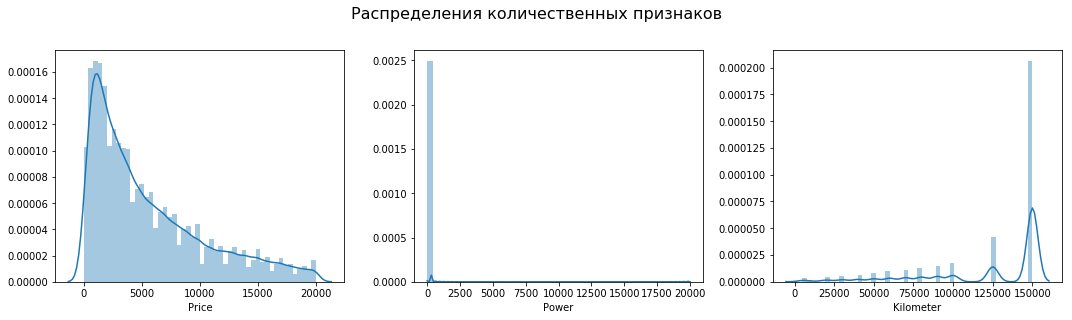

In [12]:
numeric_columns = ['Price', 'Power', 'Kilometer']
plot_columns(autos[numeric_columns], 'Распределения количественных признаков')

- #### Значения цены и мощности не могут быть равными нулю, будем считать эти значения выбросами

In [13]:
autos.drop(autos[(autos.Price == 0) | (autos.Power == 0)].index, inplace=True)

In [14]:
autos.info()

display(autos.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176044 entries, 3 to 354367
Data columns (total 9 columns):
Price          176044 non-null int64
VehicleType    176044 non-null object
Gearbox        176044 non-null object
Power          176044 non-null int64
Model          176044 non-null object
Kilometer      176044 non-null int64
FuelType       176044 non-null object
Brand          176044 non-null object
NotRepaired    176044 non-null object
dtypes: int64(3), object(6)
memory usage: 13.4+ MB


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,no
10,2000,sedan,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,manual,140,passat,150000,gasoline,volkswagen,yes
14,17999,suv,manual,190,navara,70000,gasoline,nissan,no
17,1750,small,auto,75,twingo,150000,petrol,renault,no
18,7550,bus,manual,136,c_max,150000,gasoline,ford,no
19,1850,bus,manual,102,a_klasse,150000,petrol,mercedes_benz,no


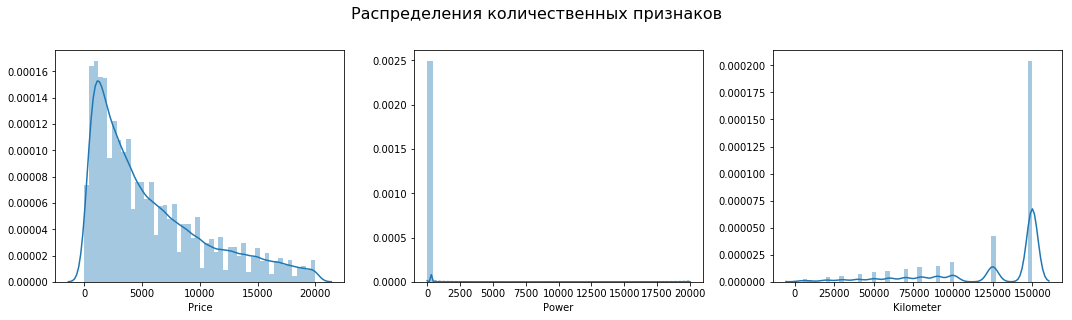

In [15]:
numeric_columns = ['Price', 'Power', 'Kilometer']
plot_columns(autos[numeric_columns], 'Распределения количественных признаков')

- #### Показатели мощности лучших суперкаров едва превышают 1000 л.с., а среднее значение для автомобилей составляет не более 200 максимум 350 л.с., это говорит о том, что показатели мощности, приведенные в таблице, могут быть на порядок завышены

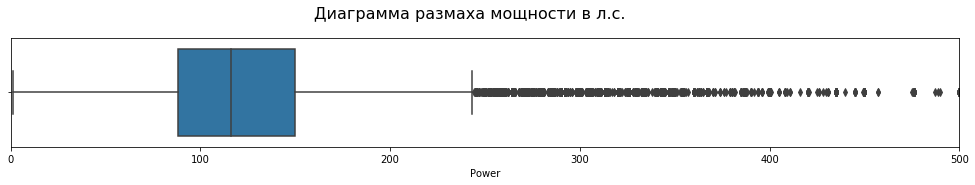

In [16]:
boxplot_column(autos.Power, 0, 500, 'Диаграмма размаха мощности в л.с.')

- #### Будем считать все что выше 350 л.с. выбросами 

In [17]:
autos.drop(autos[(autos.Power > 350)].index, inplace=True)

In [18]:
autos.info()

display(autos.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175350 entries, 3 to 354367
Data columns (total 9 columns):
Price          175350 non-null int64
VehicleType    175350 non-null object
Gearbox        175350 non-null object
Power          175350 non-null int64
Model          175350 non-null object
Kilometer      175350 non-null int64
FuelType       175350 non-null object
Brand          175350 non-null object
NotRepaired    175350 non-null object
dtypes: int64(3), object(6)
memory usage: 13.4+ MB


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,no
10,2000,sedan,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,manual,140,passat,150000,gasoline,volkswagen,yes
14,17999,suv,manual,190,navara,70000,gasoline,nissan,no
17,1750,small,auto,75,twingo,150000,petrol,renault,no
18,7550,bus,manual,136,c_max,150000,gasoline,ford,no
19,1850,bus,manual,102,a_klasse,150000,petrol,mercedes_benz,no


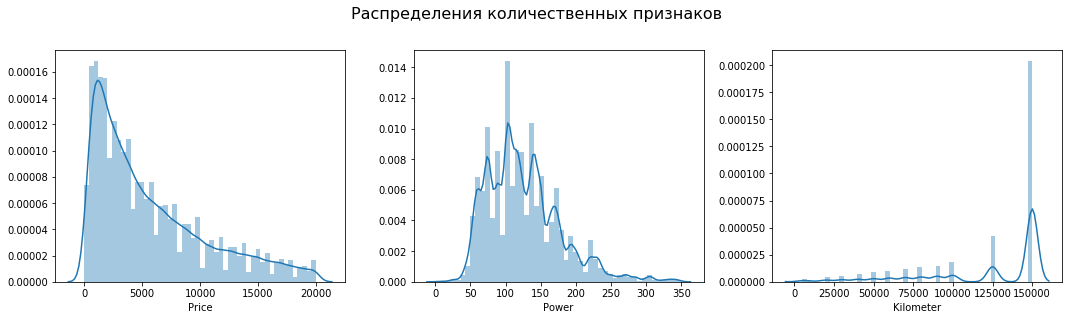

In [19]:
numeric_columns = ['Price', 'Power', 'Kilometer']
plot_columns(autos[numeric_columns], 'Распределения количественных признаков')

- #### Теперь распределения количественных признаков выглядят адекватно

- #### Оценим корреляцию между количественными признаками

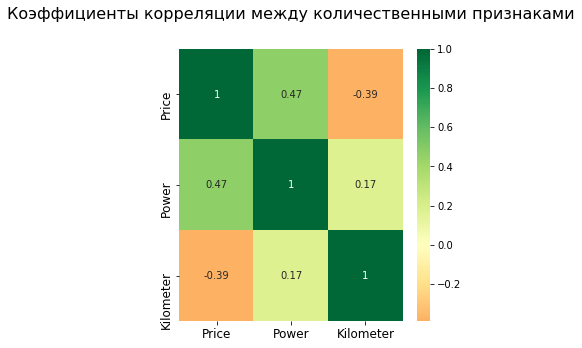

In [20]:
numeric_columns = ['Price', 'Power', 'Kilometer']

corr_columns(autos[numeric_columns], 'Коэффициенты корреляции между количественными признаками')

- #### Между признаками для обучения корреляции не наблюдается 
- #### Между признаками для обучения и целевым наблюдаются слабые корреляции

- #### Рассмотрим значения качественных признаков

In [21]:
char_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

unique_values(autos[char_columns])

------------------------------------------------------------------------------------------------------------------------
Уникальные значения VehicleType :

 ['small', 'sedan', 'convertible', 'wagon', 'suv', 'bus', 'coupe', 'other'] 

------------------------------------------------------------------------------------------------------------------------
Уникальные значения Gearbox :

 ['manual', 'auto'] 

------------------------------------------------------------------------------------------------------------------------
Уникальные значения Model :

 ['golf', 'fabia', '3er', '2_reihe', '3_reihe', 'passat', 'navara', 'twingo', 'c_max', 'a_klasse', 'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter', 'punto', 'e_klasse', 'one', 'clio', '1er', 'b_klasse', 'fortwo', 'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort', 'forester', 'scenic', 'a1', 'focus', 'tt', 'astra', 'a6', 'jazz', 'polo', 'slk', '7er', 'combo', '80', '147', 'z_reihe', 'ibiza', 'mus

- #### Значения качественных признаков в редакции не нуждаются

- #### Необходимо закодировать качественные признаки


- Для столбцов VehicleType, Gearbox, FuelType, NotRepaired мы можем применить стандартную кодировку one-hot-encoding ("one")

In [22]:
ohe_columns = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']

autos = ohe_encoding(autos, ohe_columns)

In [23]:
autos.info()

display(autos.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175350 entries, 3 to 354367
Data columns (total 20 columns):
Price                      175350 non-null int64
Power                      175350 non-null int64
Model                      175350 non-null object
Kilometer                  175350 non-null int64
Brand                      175350 non-null object
VehicleType_convertible    175350 non-null uint8
VehicleType_coupe          175350 non-null uint8
VehicleType_other          175350 non-null uint8
VehicleType_sedan          175350 non-null uint8
VehicleType_small          175350 non-null uint8
VehicleType_suv            175350 non-null uint8
VehicleType_wagon          175350 non-null uint8
Gearbox_manual             175350 non-null uint8
FuelType_electric          175350 non-null uint8
FuelType_gasoline          175350 non-null uint8
FuelType_hybrid            175350 non-null uint8
FuelType_lpg               175350 non-null uint8
FuelType_other             175350 non-null uint8
FuelT

,Price,Power,Model,Kilometer,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
3,1500,75,golf,150000,volkswagen,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
4,3600,69,fabia,90000,skoda,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
5,650,102,3er,150000,bmw,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1
6,2200,109,2_reihe,150000,peugeot,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
10,2000,105,3_reihe,150000,mazda,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


- В столбце Model и Brand слишком много категорий, поэтому кодирование ohe чрезмерно увеличит размеры датасета


- Для категорий столбца Model и Brand воспользуемся порядковым кодированием:

    1. Пронумеруем все категории

    2. Проведем нормировку для того, чтобы значения категорий не сильно выделялись на фоне остальных признаков, которые в дальнейшем будут масштабированы

In [24]:
display(pd.DataFrame.from_dict(ordinal_encoding_dict(autos, 'Model'), orient='index', columns=['Значение категории']).head())

,Значение категории
modus,0.351
ka,0.508
note,0.758
grand,0.460
leon,0.399


In [25]:
display(pd.DataFrame.from_dict(ordinal_encoding_dict(autos, 'Brand'), orient='index', columns=['Значение категории']).head())

,Значение категории
rover,0.816
volvo,0.763
nissan,0.132
mercedes_benz,0.211
suzuki,0.684


In [26]:
autos.replace({"Model": ordinal_encoding_dict(autos, 'Model')}, inplace=True)

In [27]:
autos.replace({"Brand": ordinal_encoding_dict(autos, 'Brand')}, inplace=True)

In [28]:
autos.info()

display(autos.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175350 entries, 3 to 354367
Data columns (total 20 columns):
Price                      175350 non-null int64
Power                      175350 non-null int64
Model                      175350 non-null float64
Kilometer                  175350 non-null int64
Brand                      175350 non-null float64
VehicleType_convertible    175350 non-null uint8
VehicleType_coupe          175350 non-null uint8
VehicleType_other          175350 non-null uint8
VehicleType_sedan          175350 non-null uint8
VehicleType_small          175350 non-null uint8
VehicleType_suv            175350 non-null uint8
VehicleType_wagon          175350 non-null uint8
Gearbox_manual             175350 non-null uint8
FuelType_electric          175350 non-null uint8
FuelType_gasoline          175350 non-null uint8
FuelType_hybrid            175350 non-null uint8
FuelType_lpg               175350 non-null uint8
FuelType_other             175350 non-null uint8
Fue

,Price,Power,Model,Kilometer,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
3,1500,75,0.000,150000,0.000,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
4,3600,69,0.004,90000,0.026,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
5,650,102,0.008,150000,0.053,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1
6,2200,109,0.012,150000,0.079,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
10,2000,105,0.016,150000,0.105,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


- #### Итоговый порядок подготовки данных:


    1. Чтение датасета

    2. Удаление лишних столбцов

    3. Удаление пропусков

    4. Удаление дубликатов

    5. Удаление значений превышающих лимиты

    6. OHE кодирование

    7. Порядковое кодирование

- Параметры подготовки данных:

In [29]:
dataset_path = 'autos.csv'

drop_columns = ['DateCrawled', 'RegistrationYear', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']
ohe_encoding_columns = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']
ordinal_encoding_columns = ['Model', 'Brand']

power_limit = [0, 350]
price_limit = [0, math.inf]
kilometer_limit = [0, math.inf]

- Подготовка данных:

In [30]:
autos = pd.DataFrame()

autos = prepare_data(dataset_path, drop_columns, power_limit, price_limit, kilometer_limit, ohe_encoding_columns, ordinal_encoding_columns)

- Вывод результата подготовки:

In [31]:
autos.info()

display(autos.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175336 entries, 3 to 354367
Data columns (total 20 columns):
Price                      175336 non-null int64
Power                      175336 non-null int64
Model                      175336 non-null float64
Kilometer                  175336 non-null int64
Brand                      175336 non-null float64
VehicleType_convertible    175336 non-null uint8
VehicleType_coupe          175336 non-null uint8
VehicleType_other          175336 non-null uint8
VehicleType_sedan          175336 non-null uint8
VehicleType_small          175336 non-null uint8
VehicleType_suv            175336 non-null uint8
VehicleType_wagon          175336 non-null uint8
Gearbox_manual             175336 non-null uint8
FuelType_electric          175336 non-null uint8
FuelType_gasoline          175336 non-null uint8
FuelType_hybrid            175336 non-null uint8
FuelType_lpg               175336 non-null uint8
FuelType_other             175336 non-null uint8
Fue

,Price,Power,Model,Kilometer,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
3,1500,75,0.000,150000,0.000,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
4,3600,69,0.004,90000,0.026,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
5,650,102,0.008,150000,0.053,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1
6,2200,109,0.012,150000,0.079,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
10,2000,105,0.016,150000,0.105,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


- #### Разделим признаки на целевые (y) и обучающие (X)

In [32]:
X = autos.drop(columns=['Price'], axis=1)
y = autos['Price']

- #### Разделим датасет на выборки для тестрования и обучения в соотношении 25:75

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

- #### Проведем масштабирование количественных признаков для обучающей выборки

In [34]:
warnings.filterwarnings('ignore')

scale_columns = ['Power', 'Kilometer']

scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(X_train[scale_columns]) 

X_train[scale_columns] = scaler.transform(X_train[scale_columns])

In [35]:
display(X_train.head())

,Power,Model,Kilometer,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
93404,0.660920,0.185,0.655172,0.053,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
275966,0.419540,0.052,1.000000,0.184,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
180066,0.310345,0.036,0.448276,0.211,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
1990,0.419540,0.379,0.241379,0.579,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
19670,0.298851,0.000,1.000000,0.000,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


# 2. Обучение моделей

- Для оценки качества будем использовать метрику RMSE и дополнительно R2

In [36]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

- #### Построим модели градиентного бустинга

- Зададим модель

In [37]:
estimator = lgb.LGBMRegressor(random_state=RANDOM_STATE)

- Определим параметры для тестирования

In [38]:
param_grid = {
    'num_leaves' : [30, 50, 70],
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100]
}

- Зададим параметры сетки подбора модели

In [39]:
model_gbm = GridSearchCV(estimator, param_grid, cv=3, scoring=rmse_scorer)

- Обучим модели на сетке параметров

%%time
model_gbm.fit(X_train, y_train)

- Оценим характеристики лучшей модели

In [41]:
params = model_gbm.best_params_

results_gbm = learing_results(estimator, params, X_train, y_train, X_train, y_train)

display(results_gbm)

,Метрика RMSE,Метрика R2,"Время обучения, с","Время предсказания, с"
LGBMRegressor,2487,0.74,0.64,0.43


- #### Построим модель решающего дерева

- Зададим модель

In [42]:
estimator = DecisionTreeRegressor(random_state=RANDOM_STATE)

- Определим параметры для тестирования

In [43]:
param_grid = {
    'criterion' : ['mse'],
    'max_depth' : [2, 10, 20, 30],
    'splitter' : ['best', 'random'],
    'max_features' : ['auto', 'sqrt', 'log2']
}

- Зададим параметры сетки подбора модели

In [44]:
model_decision_tree = GridSearchCV(estimator, param_grid, cv=3, scoring=rmse_scorer)

- Обучим модели на сетке параметров

In [45]:
%%time
model_decision_tree.fit(X_train, y_train)

Wall time: 13.9 s


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=12345, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 10, 20, 30], 'max_features': ['auto', 'sqrt', 'log2'], 'criterion': ['mse'], 'splitter': ['best', 'random']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse, greater_is_better=False), verbose=0)

- Оценим характеристики лучшей модели

In [46]:
params = model_decision_tree.best_params_

results_decision_tree = learing_results(estimator, params, X_train, y_train, X_train, y_train)

display(results_decision_tree)

,Метрика RMSE,Метрика R2,"Время обучения, с","Время предсказания, с"
DecisionTreeRegressor,1530,0.9,0.6,0.06


- #### Построим модель случайного леса

- Зададим модель

In [47]:
estimator = RandomForestRegressor(random_state=RANDOM_STATE)

- Определим параметры для тестирования

In [48]:
param_grid = {
    'n_estimators' : [100, 150],
    'criterion': ['mse'],
    'max_depth' : [2, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

- Зададим параметры сетки подбора модели

In [49]:
model_random_forest = GridSearchCV(estimator, param_grid, cv=3, scoring=rmse_scorer)

- Обучим модели на сетке параметров

In [50]:
%%time
model_random_forest.fit(X_train, y_train)

Wall time: 5min 3s


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=12345, verbose=0,
           warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 150], 'max_depth': [2, 10], 'max_features': ['auto', 'sqrt', 'log2'], 'criterion': ['mse']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse, greater_is_better=False), verbose=0)

- Оценим характеристики лучшей модели

In [51]:
params = model_random_forest.best_params_

results_random_forest = learing_results(estimator, params, X_train, y_train, X_train, y_train)

display(results_random_forest)

,Метрика RMSE,Метрика R2,"Время обучения, с","Время предсказания, с"
RandomForestRegressor,1663,0.88,4.21,0.46


- #### Оценим резульаты моделей на этапе подбора оптимальных параметров обучения:

In [52]:
display(pd.concat([results_gbm, results_decision_tree, results_random_forest]))

,Метрика RMSE,Метрика R2,"Время обучения, с","Время предсказания, с"
LGBMRegressor,2487,0.74,0.64,0.43
DecisionTreeRegressor,1530,0.90,0.60,0.06
RandomForestRegressor,1663,0.88,4.21,0.46


- Каждая из моделей показала удовлетворительные результаты на этапе обучения


- Лучше показатели качества соответсвуют модели DecisionTreeRegressor (- Решающее дерево)


- Самые низкие показатели качества соответсвуют модели LGBMRegressor (- Градиентный бустинг)

# 3. Анализ моделей

- #### Сравним результаты моделей на тестовых данных

- Подготовим признаки на тестовой выборке

In [53]:
print('Признаки тестовой выборки до масштабирования:')
display(X_test.head())

X_test[scale_columns] = scaler.transform(X_test[scale_columns])

print('\nПризнаки тестовой выборки после масштабирования:')
display(X_test.head())

Признаки тестовой выборки до масштабирования:


,Power,Model,Kilometer,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
334267,61,0.089,20000,0.342,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
138829,110,0.379,150000,0.579,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0
25332,105,0.383,90000,0.026,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
200003,133,0.500,150000,0.289,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
227321,166,0.052,50000,0.395,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0



Признаки тестовой выборки после масштабирования:


,Power,Model,Kilometer,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
334267,0.172414,0.089,0.103448,0.342,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
138829,0.313218,0.379,1.000000,0.579,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0
25332,0.298851,0.383,0.586207,0.026,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
200003,0.379310,0.500,1.000000,0.289,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
227321,0.474138,0.052,0.310345,0.395,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


- Модель градиентного бустинга

In [54]:
estimator = lgb.LGBMRegressor(random_state=RANDOM_STATE)

params = model_gbm.best_params_

test_results_gbm = learing_results(estimator, params, X_train, y_train, X_test, y_test)

- Модель решающего дерева

In [55]:
estimator = DecisionTreeRegressor(random_state=RANDOM_STATE)

params = model_decision_tree.best_params_

test_results_decision_tree = learing_results(estimator, params, X_train, y_train, X_test, y_test)

- Модель случайный лес

In [56]:
estimator = RandomForestRegressor(random_state=RANDOM_STATE)

params = model_random_forest.best_params_

test_results_random_forest = learing_results(estimator, params, X_train, y_train, X_test, y_test)

- #### Подведем итоги:

In [57]:
total_results = pd.concat([test_results_gbm, test_results_decision_tree, test_results_random_forest]).sort_values(by='Метрика RMSE', ascending=True)

display(total_results)

,Метрика RMSE,Метрика R2,"Время обучения, с","Время предсказания, с"
RandomForestRegressor,2318,0.77,4.12,0.17
LGBMRegressor,2526,0.73,0.71,0.17
DecisionTreeRegressor,2575,0.72,0.63,0.02


- Приведем качественные характеристики моделей

In [58]:
total_results = { 'Качество предсказания' : ['Высокое', 'Среднее', 'Низкое'],
                  'Скорость предсказания' : ['Низкая', 'Низкая', 'Высокая'],
                  'Время обучения' : ['Большое', 'Среднее', 'Малое']
                 }
columns = ['Качество предсказания', 'Скорость предсказания', 'Время обучения']

index = ['Случайный лес', 'Градиентный бустинг', 'Решающее дерево']

display(pd.DataFrame(total_results, columns=columns, index=index))

,Качество предсказания,Скорость предсказания,Время обучения
Случайный лес,Высокое,Низкая,Большое
Градиентный бустинг,Среднее,Низкая,Среднее
Решающее дерево,Низкое,Высокая,Малое


- #### Общий вывод

- Каждая модель имеет свои преуимущества и недостатки


- Модель "случайный лес" подойдет, если требуется получить наилучшее качество, но при этом время предсказания и обучения будет относительно большим


- Модель "градиентного бустинга" - золотая середина между качеством и скорость обучения/предсказания


- Модель "решающее дерево" - имеет самое низкое качество, но быстрее всех справляется с обучением и предсказанием